In [1]:
import time
from datetime import datetime
from pydoc import locate
import matplotlib.pyplot as plt
import logging

from config import config
from models.mysqldb import Mysqldb
from models.task import Task

logging.basicConfig(level=logging.INFO)

start_time = time.time()    

db = Mysqldb(config['db'])

project_id = 3
task_list = Task.get_list(db=db, active=1)
task_counter = 0
for task_info in task_list:
    task = Task.get_task(db=db, id=task_info['id'])
    if task:
        if task.id!=18:
            continue

        if not 'data' in task.info['task_settings']:
            task.info['task_settings']['data'] = {}       
        task.info['task_settings']['data']['project_id'] = task.project_id
        task.info['task_settings']['data']['metric_tag_id'] = 0
        task.info['task_settings']['data']['metric_id'] = task.info['metric_id']
        task.info['task_settings']['data']['granularity'] = task.info['granularity']
        task.info['task_settings']['message_lvl'] = task.info['message_lvl']

        job_id = task.create_job()
        print(f"Create job [{job_id}] for task [{task.id}] with robot {task.info['task_robot']}")
 
        Robot_class = locate('models.robot_'+task.info['task_robot']+'.Robot_'+task.info['task_robot'])  
        robot = Robot_class(settings=task.info['task_settings'], config=config)
        robot_res = robot.run(output=True)

        res = robot_res['data']
        anoms = robot_res['anoms']
        anoms_pos = robot_res['anoms_pos']
        anoms_neg = robot_res['anoms_neg']
        job_telemetry = robot_res["telemetry"]

        if not res is None and len(res)>0:
            # direction options: pos | neg | both
            print('res items: ', len(res))
            if len(res)>0:
                fig, ax = plt.subplots(1, figsize=(15,5))
                res.plot(ax=ax)
                if not anoms is None and task.info['task_settings']['anoms']['direction']=='bothsplit':
                    ax.scatter(anoms.index.values, anoms, color='red')
                else:    
                    if not anoms_pos is None:
                        ax.scatter(anoms_pos.index.values, anoms_pos, color='green')
                    if not anoms_neg is None:
                        ax.scatter(anoms_neg.index.values, anoms_neg, color='red')
                ax.set_xlabel('Date time')
                ax.set_ylabel('Count')
                ax.set_title('Twitter Raw Data')
            else:
                print('No Data for metric!') 

        formatted_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        task.update_job(job_execution_sec=job_telemetry["job_execution_sec"], 
                        job_max_mem_kb=job_telemetry["job_max_mem_kb"], 
                        job_dt_fin=formatted_time, job_status='fin', job_comment=robot_res["comment"])
        
        print(f"Fin job [{job_id}] for task [{task.id}], job_execution_sec: {job_telemetry['job_execution_sec']}")
        print("----------------")
        task_counter += 1

all_execution_sec = round(time.time() - start_time, 4)
message_str = f'Monitor fin {task_counter} tasks in {all_execution_sec} sec'
# Message.send(message_str, lvl='log') # Нужно только для запусков по крону из py скрипта
print(message_str)


INFO:mysql.connector:package: mysql.connector.plugins
INFO:mysql.connector:plugin_name: caching_sha2_password
INFO:mysql.connector:AUTHENTICATION_PLUGIN_CLASS: MySQLCachingSHA2PasswordAuthPlugin


Monitor fin 0 tasks in 0.0239 sec


INFO:root:Robot twanom run with metric [202] success_execution_time dp: [3]
INFO:root:Add anoms in direction: neg; last_anom_dt: 2025-11-06 15:00:00+03:00; all anoms: 72; add anoms: 0
INFO:root:Add anoms in direction: pos; last_anom_dt: 2025-11-06 15:00:00+03:00; all anoms: 53; add anoms: 0


res items:  1062


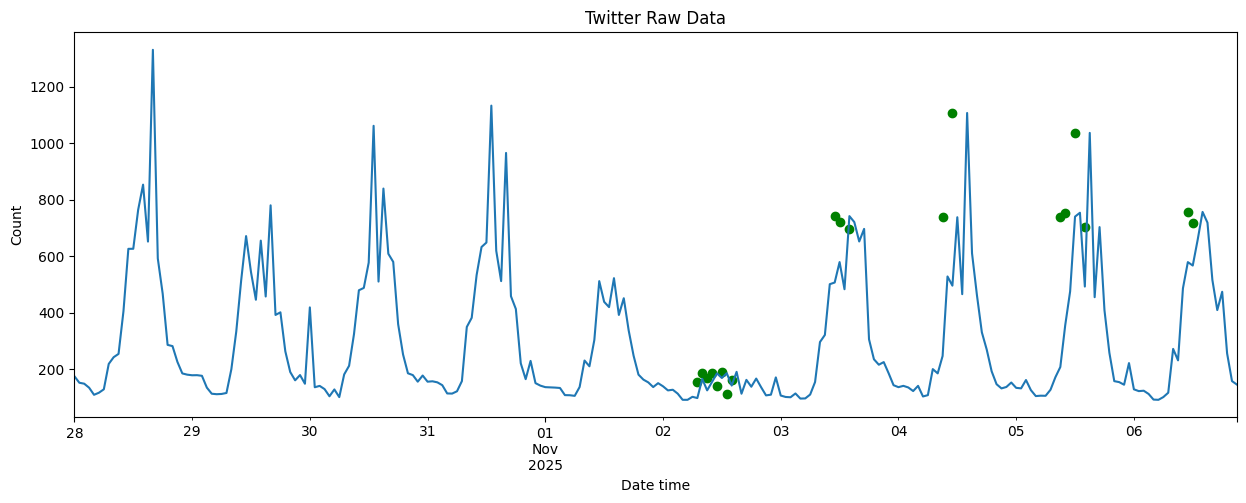

In [3]:
import time
from datetime import timedelta, datetime
from pydoc import locate
import matplotlib.pyplot as plt
import logging

from config import config
from models.mysqldb import Mysqldb
from models.sysbf import SysBf

from models.robot_twanom import Robot_twanom

logging.basicConfig(level=logging.INFO)  

db = Mysqldb(config['db'])

task_settings = {
    "data":{
        "dt_from": '',
        "project_id": 3,
        "metric_tag_id": 0,
        "metric_id": 202, 
        "granularity":"h1",
        "accum_items": 4 
    },
    "anoms":{
        "direction": "both", 
        "max_anoms": 0.2, 
        "alpha": 0.01, 
        "piecewise_median_period_weeks": 2
    },
    "message_lvl":"all"
}

robot = Robot_twanom(settings=task_settings, config=config)
robot_res = robot.run(output=True)

res = robot_res['data']
anoms = robot_res['anoms']
anoms_pos = robot_res['anoms_pos']
anoms_neg = robot_res['anoms_neg']
job_telemetry = robot_res["telemetry"]

if not res is None and len(res)>0:
    # direction options: pos | neg | both
    print('res items: ', len(res))
    if len(res)>0:
        datetime_from = SysBf.tzdt(datetime.now() - timedelta(days=15), "Europe/Moscow")
        res2 = SysBf.filter_series_by_datetime(res, datetime_from)
        fig, ax = plt.subplots(1, figsize=(15,5))
        res2.plot(ax=ax)
        if len(anoms_pos)>0:
            anoms_pos2 = SysBf.filter_series_by_datetime(anoms_pos, datetime_from)
            ax.scatter(anoms_pos2.index.values, anoms_pos2, color='green')
        if len(anoms_neg)>0:
            anoms_neg2 = SysBf.filter_series_by_datetime(anoms_neg, datetime_from)
            ax.scatter(anoms_neg2.index.values, anoms_neg2, color='red')
        if task_settings['anoms']['direction']=='bothsplit' and len(anoms)>0:
            anoms2 = SysBf.filter_series_by_datetime(anoms, datetime_from)
            ax.scatter(anoms2.index.values, anoms2, color='yellow') 
        ax.set_xlabel('Date time')
        ax.set_ylabel('Count')
        ax.set_title('Twitter Raw Data')
    else:
        print('No Data for metric!') 
